In [42]:
# %load Classification.py
import numpy as np
import pandas as pd
import nltk
import gensim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
#read file from local
df = pd.read_csv('merged.csv',index_col=None,header=0)
df['label'] = np.nan

df['label'] = np.where(df['rating'] >3,0,1)



In [43]:
df.head()

,title,rating,body,product_id,review_date,label
0,Skip this one.,2,I've been a big fan of Canon printers for almo...,B07G5XZVLG,"Reviewed in the United States on September 11,...",1
1,Worst setup process I ever faced,1,I followed the instructions to connect a print...,B07G5XZVLG,"Reviewed in the United States on November 3, 2018",1
2,INK ISNT REALLY LOW,4,I love this printer. I needed something I coul...,B07G5XZVLG,"Reviewed in the United States on January 31, 2019",0
3,"Google Cloud print compatible, NOT CLOUD READY...",5,"First, while this printer CAN be registered wi...",B07G5XZVLG,"Reviewed in the United States on December 26, ...",0
4,"Not user friendly, but good print quality",4,"Bought the white version which I like, but it’...",B07G5XZVLG,"Reviewed in the United States on December 9, 2018",0


In [48]:
corpus, labels = df['body'], df['label']
# split training dataset and testing dataset
train_corpus, test_corpus, train_labels, test_labels = train_test_split(corpus,
                                                                        labels,
                                                                        test_size=0.3)

#bow features
from sklearn.feature_extraction.text import CountVectorizer #tokenizes and counts words
# build bag of words features' vectorizer and get features
bow_vectorizer=CountVectorizer(min_df=1, ngram_range=(1,1))
bow_train_features = bow_vectorizer.fit_transform(train_corpus.values.astype('U'))
bow_test_features = bow_vectorizer.transform(test_corpus)


In [52]:

corpus, labels = df['body'], df['label']
# split training dataset and testing dataset
train_corpus, test_corpus, train_labels, test_labels = train_test_split(corpus,
                                                                        labels,
                                                                        test_size=0.3)

#bow features
from sklearn.feature_extraction.text import CountVectorizer #tokenizes and counts words
# build bag of words features' vectorizer and get features
bow_vectorizer=CountVectorizer(min_df=1, ngram_range=(1,1))
bow_train_features = bow_vectorizer.fit_transform(train_corpus.values.astype('U'))
bow_test_features = bow_vectorizer.transform(test_corpus.values.astype('U'))

# tfidf features
from sklearn.feature_extraction.text import TfidfVectorizer #alternatively, use TfidfTransformer()

tfidf_vectorizer=TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
tfidf_train_features = tfidf_vectorizer.fit_transform(train_corpus.values.astype('U'))
tfidf_test_features = tfidf_vectorizer.transform(test_corpus.values.astype('U'))


# tokenize documents for word2vec
tokenized_train = [nltk.word_tokenize(text)
                   for text in train_corpus.values.astype('U')]
tokenized_test = [nltk.word_tokenize(text)
                   for text in test_corpus.values.astype('U')]

# build word2vec model
wv_model = gensim.models.Word2Vec(tokenized_train,
                               size=200,                          #set the size or dimension for the word vectors
                               window=60,                        #specify the length of the window of words taken as context
                               min_count=10)                   #ignores all words with total frequency lower than

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

# averaged word vector features from word2vec
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,model=wv_model,num_features=200)
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,model=wv_model,num_features=200)

#Define metrics for evaluation
from sklearn import metrics

# define a function to evaluate our classification models based on four metrics
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels,predicted_labels),2))
    print('Precision:', np.round(metrics.precision_score(true_labels,predicted_labels),2))
    print('Recall:', np.round(metrics.recall_score(true_labels,predicted_labels),2))
    print('F1 Score:', np.round(metrics.f1_score(true_labels,predicted_labels),2))

# define a function that trains the model, performs predictions and evaluates the predictions


C:\Users\Bommi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [70]:
def train_predict_evaluate_model(classifier,train_features, train_labels,test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    c = pd.DataFrame({'Accuracy':[np.round(metrics.accuracy_score(test_labels,predictions),2)],
                      'Precision':[np.round(metrics.precision_score(test_labels,predictions),2)],
                      'Recall':[np.round(metrics.recall_score(test_labels,predictions),2)],
                      'F1 Score':[np.round(metrics.f1_score(test_labels,predictions),2)]})
    c.plot(kind='bar',color=['tomato','mediumturquoise','slateblue','lightslategrey'])
    plt.ylim(0.7,0.9)
    plt.xticks([])
    # evaluate model prediction performance
    result = get_metrics(test_labels,predictions)
    cm = metrics.confusion_matrix(test_labels, predictions)
    a=pd.DataFrame(cm, index=range(0,2), columns=range(0,2))
    plt.figure(figsize=(5,4))
    g=sns.heatmap(a,annot=True,cmap="RdYlGn",fmt='g')
    x=list(['Product is Good','Not so Good'])
    g.set_yticklabels(x,rotation=1)
    g.set_xticklabels(x,rotation=1)
    return result

Accuracy: 0.88
Precision: 0.86
Recall: 0.83
F1 Score: 0.85


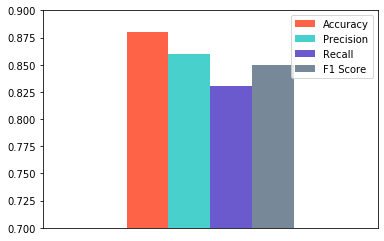

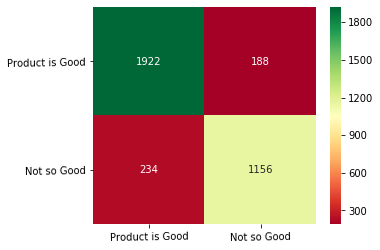

In [71]:
#Train and evaluate {mnb, svm} with bow features
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge', max_iter=100)

#Multinomial Naive Bayes with bag of words features
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,train_features=bow_train_features,train_labels=train_labels,test_features=bow_test_features,test_labels=test_labels)


Accuracy: 0.88
Precision: 0.86
Recall: 0.84
F1 Score: 0.85


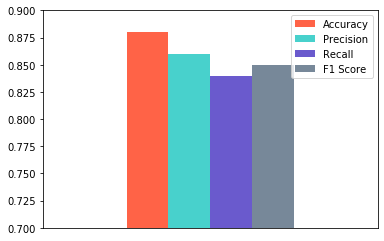

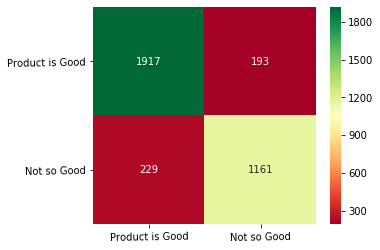

In [72]:
#Support Vector Machine with bag of words features
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,train_features=bow_train_features,train_labels=train_labels,test_features=bow_test_features,test_labels=test_labels)


Accuracy: 0.89
Precision: 0.88
Recall: 0.85
F1 Score: 0.87


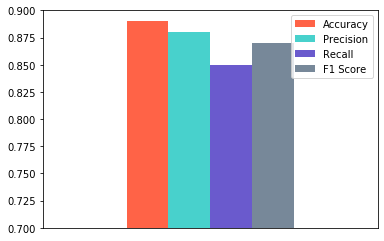

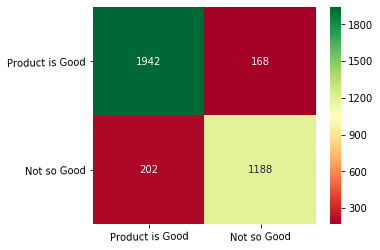

In [73]:

#Train and evaluate {svm} with {tfidf, word2vec} features
# Support Vector Machine with tfidf features
svm_tfidf_predictions = train_predict_evaluate_model(classifier=svm,train_features=tfidf_train_features,train_labels=train_labels,test_features=tfidf_test_features,test_labels=test_labels)


Accuracy: 0.82
Precision: 0.77
Recall: 0.8
F1 Score: 0.78


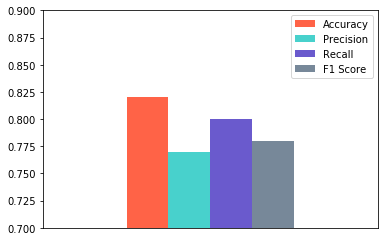

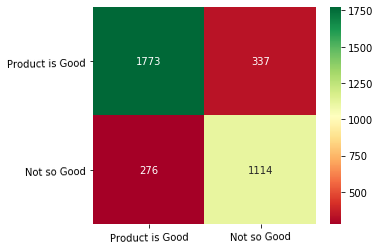

In [74]:

# Support Vector Machine with averaged word vector features
svm_avgwv_predictions = train_predict_evaluate_model(classifier=svm,train_features=avg_wv_train_features,train_labels=train_labels,test_features=avg_wv_test_features,test_labels=test_labels)


In [16]:
def graph(x,y,z,h):
    c = pd.DataFrame({'Accuracy':[x],'Precision':[y],'Recall':[z],'F1 Score':[h]})
    c.plot(kind='bar')
    plt.ylim(0.7,0.9)
    plt.xticks([])

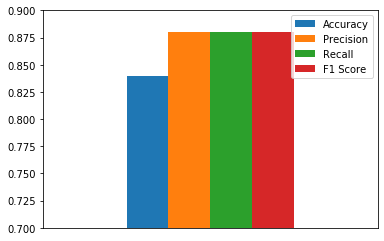

In [14]:
graph(0.84,0.88,0.88,0.88)

[Text(0.5, 0, 'Product is Good'), Text(1.5, 0, 'Not so Good')]

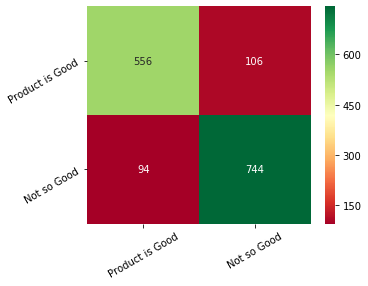

In [27]:

cm = metrics.confusion_matrix(test_labels, svm_tfidf_predictions)
a=pd.DataFrame(cm, index=range(0,2), columns=range(0,2))
plt.figure(figsize=(5,4))
g=sns.heatmap(a,annot=True,cmap="RdYlGn",fmt='g')
x=list(['Product is Good','Not so Good'])
g.set_yticklabels(x,rotation=30)
g.set_xticklabels(x,rotation=30)

